# Multivariate Gaussian Distribution

In [8]:
import numpy as np
import scipy.io as sio

# Import dataset

In [9]:
data = sio.loadmat("./ex8data1")
X = data["X"]
CV = data["Xval"]
y_CV = data["yval"]
X.shape, CV.shape, y_CV.shape

((307, 2), (307, 2), (307, 1))

# Visualizing data

Text(0, 0.5, 'Throughput')

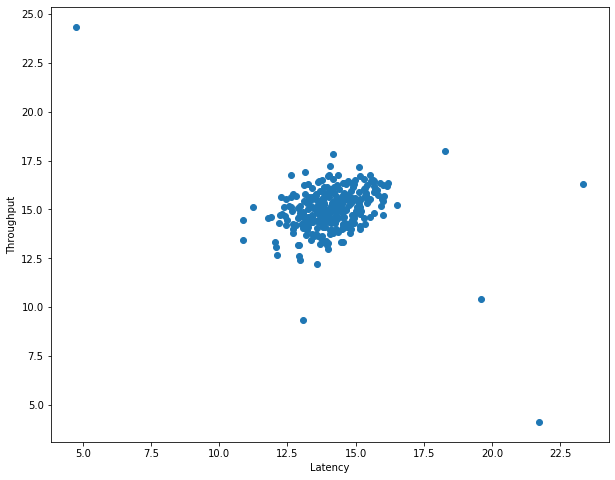

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("Latency")
plt.ylabel("Throughput")

# Calculating $\mu$ and covariance matrix
- X: (n,m) where n is column vector of features.
$$
\mu=\frac{1}{m} \sum_{i=1}^{m} x^{(i)} \in \mathbb{R}^{n}
$$
$$
\sigma\left(x_{j}, x_{k}\right) =\frac{1}{m} \sum_{i=1}^{m}\left(x_{j}^{(i)}-\mu_{j}\right)\left(x_{k}^{(i)}-\mu_{k}\right) \\
$$
Assume we have already perform mean normalization for $X$:
$$
\begin{aligned}
\Sigma &= \frac{1}{m} \sum_{i=1}^{m}\left(x^{(i)} -\mu \right)\left(x^{(i)} - \mu\right)^{T} \\
&= \frac{1}{m} \sum_{i=1}^{m}\left(x^{(i)}\right)\left(x^{(i)}\right)^{T} \\
&= \frac{1}{m}XX^{T} \in \mathbb{R}^{n \times n}
\end{aligned} 
$$

In [11]:
mu = X.mean(axis=0)
cov = np.cov(X.T) # originally X is (m,n)

# same variance
# X_nor = X - mu
# var = np.power(X_nor, 2).mean(axis=0)

mu, cov

(array([14.11222578, 14.99771051]), array([[ 1.83862041, -0.22786456],
        [-0.22786456,  1.71533273]]))

# Calculating possiblites
Orignally, the normal distribution is defined as follow:
$$
p(x)=\prod_{j=1}^{n} p\left(x_{j} ; \mu, \sigma_{j}^{2}\right)=\prod_{j=1}^{n} \frac{1}{\sqrt{2 \pi} \sigma_{j}} \exp \left(-\frac{\left(x_{j}-\mu_{j}\right)^{2}}{2 \sigma_{j}^{2}}\right)
$$
For the multivariate normal distribution, the inverse of $\Sigma$ is actually the $\sigma^2$ term in the denominator. We always assume the feature vector is a column vector $\in \mathbb{R}^{n}$ i.e $X$ is (n,m).
$$
p(x^{(i)})=\frac{1}{(2 \pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}} \exp \left(-\frac{1}{2}(x^{(i)}-\mu)^{T} \Sigma^{-1}(x^{(i)}-\mu)\right)
$$
$$
diagonal(p(X))  \in \mathbb{R}^{m}
$$

In [12]:
def multi_norm(X, mu, cov):
    m,n = X.shape
    det = np.linalg.det(cov) 
    inv = np.linalg.inv(cov)

    ce = (1 / (np.power((2 * np.pi), n/2) * np.power(det, 0.5)))
    p = ce * np.exp(-0.5 * ((X-mu) @ inv @ (X-mu).T))
    return p.diagonal()

# This function performs exeactly same as follow: 
# from scipy import stats
# mgd = stats.multivariate_normal(mu, cov)
# p = mgd.pdf(X).reshape(p.shape[0],1)
# p_cv = mgd.pdf(CV).reshape(p_cv.shape[0],1)

In [13]:
p = np.zeros(X.shape)
p_cv = np.zeros(CV.shape)
p = multi_norm(X, mu, cov).reshape(p.shape[0],1)
p_cv = multi_norm(CV, mu, cov).reshape(p_cv.shape[0],1)

# Learning threshold $\epsilon$ from CV
Recall the definitions of precisoin and recall:
$$
\begin{aligned}
p r e c &=\frac{t p}{t p+f p} \\
r e c &=\frac{t p}{t p+f n}
\end{aligned}
$$
And $F_1$ score is harmonic mean that is computed using precision and recall:
$$
F_{1}=\frac{2 \cdot p r e c \cdot r e c}{p r e c +r e c}
$$
We want a threshold $epsilon$ that makes $F_1$ as large as possible so as to optimize both precison and recall.

In [14]:
def select_thres(p_cv, y_CV, max_iters=1000):
    best_e = 0
    best_f1 = 0
    
    step = (p_cv.max() - p_cv.min()) / max_iters
    
    for e in np.arange(p_cv.min(), p_cv.max(), step):
        preds = p_cv < e # (m,n) boolean matrix
        
        tp = np.sum(np.logical_and(preds == True, y_CV == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == True, y_CV == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == False, y_CV == 1)).astype(float)
        
        prec = tp / (tp + fp) if tp + fp > 0 else 0
        rec = tp / (tp + fn) if tp + fn > 0 else 0
        f_1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
        
        if f_1 > best_f1:
            best_f1 = f_1
            best_e = e
            
    return best_e, best_f1

In [15]:
e, f_1 = select_thres(p_cv, y_CV)
e, f_1

(9.036240676156382e-05, 0.8750000000000001)

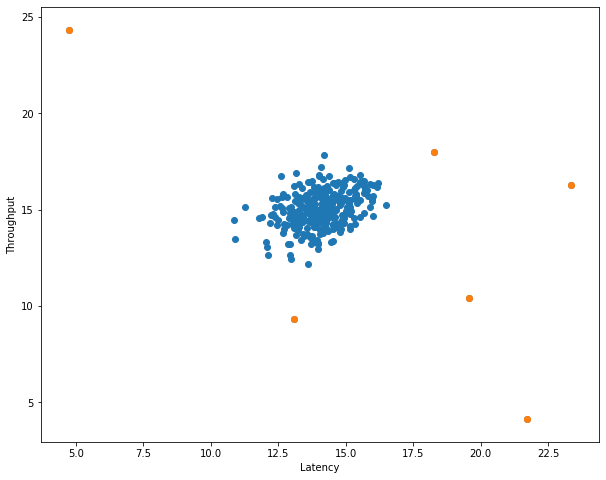

In [17]:
X_outliers = np.where(p < e) # indexs of the outliers

plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X[X_outliers[0], 0], X[X_outliers[0], 1])
plt.xlabel("Latency")
plt.ylabel("Throughput")
plt.show()